In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score, precision_score, 
                             recall_score, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df = df.drop_duplicates()

# Drop multicollinearity features
df = df.drop(['emp.var.rate', 'nr.employed'], axis=1)
df = df.drop(['duration'], axis=1)

# Separate features and target
X = df.drop('y', axis=1)
y = df['y'].map({'no': 0, 'yes': 1})
print(f"Dataset shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Dataset shape: (41176, 17)
Target distribution: {0: 36537, 1: 4639}


In [22]:
# Cell 3: Encode Categorical Variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
le_dict = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    le_dict[col] = le

print(f"\nCategorical columns encoded: {len(categorical_cols)}")


Categorical columns encoded: 10


In [23]:
# Cell 4: Train-Test Split (NO scaling needed for Decision Tree)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 32940
Test set size: 8236


In [24]:
# Cell 5: Train Decision Tree with Hyperparameter Tuning
# Limited depth to improve interpretability and avoid overfitting
dt_classifier = DecisionTreeClassifier(
    max_depth=7,  # Limit depth for interpretability
    min_samples_split=50,  # Require at least 50 samples to split
    min_samples_leaf=20,  # Require at least 20 samples in leaf nodes
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)
dt_classifier.fit(X_train, y_train)
print("Decision Tree trained successfully!")

Decision Tree trained successfully!


In [25]:
# Cell 6: Make Predictions
y_train_pred = dt_classifier.predict(X_train)
y_train_pred_proba = dt_classifier.predict_proba(X_train)[:, 1]

y_test_pred = dt_classifier.predict(X_test)
y_test_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

In [26]:
# Cell 7: Model Evaluation - Training Set
print("\n" + "="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_train_pred == y_train).mean():.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_pred_proba):.4f}")


TRAINING SET PERFORMANCE
Accuracy: 0.8521
Precision: 0.3992
Recall: 0.6200
F1-Score: 0.4857
ROC-AUC: 0.8124


In [27]:
# Cell 8: Model Evaluation - Test Set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Conversion', 'Conversion']))


TEST SET PERFORMANCE
Accuracy: 0.8582
Precision: 0.4151
Recall: 0.6325
F1-Score: 0.5013
ROC-AUC: 0.8142

Classification Report (Test Set):
               precision    recall  f1-score   support

No Conversion       0.95      0.89      0.92      7308
   Conversion       0.42      0.63      0.50       928

     accuracy                           0.86      8236
    macro avg       0.68      0.76      0.71      8236
 weighted avg       0.89      0.86      0.87      8236



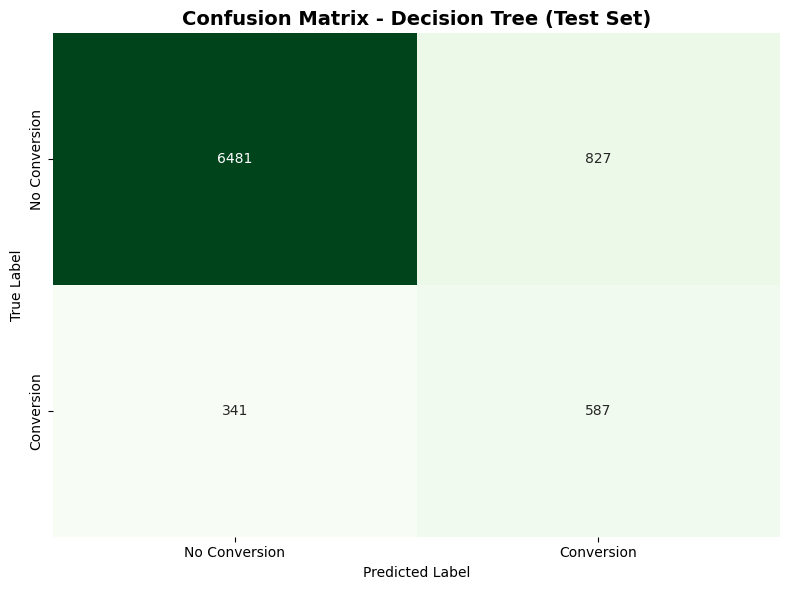

In [28]:
# Cell 9: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Conversion', 'Conversion'],
            yticklabels=['No Conversion', 'Conversion'])
plt.title('Confusion Matrix - Decision Tree (Test Set)', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

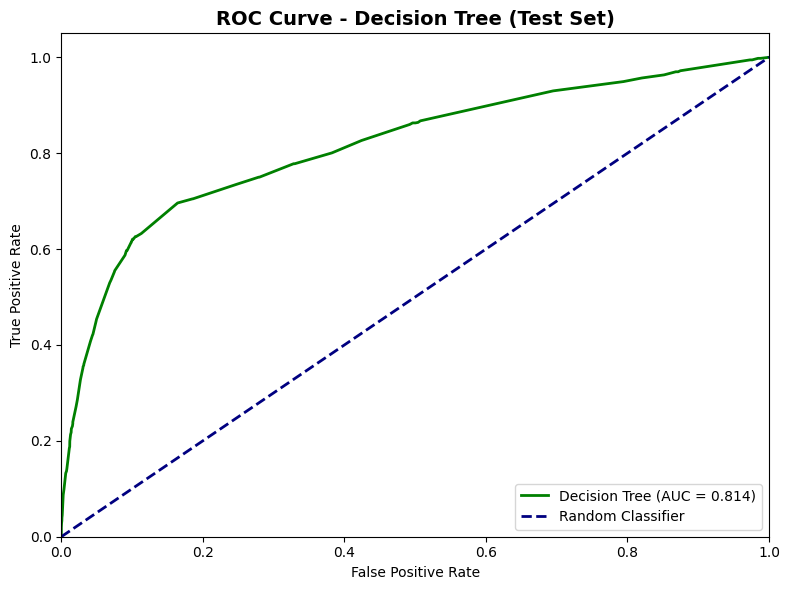

In [29]:
# Cell 10: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Test Set)', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [30]:
# Cell 11: Feature Importance Analysis
feature_names = X_encoded.columns.tolist()
feature_importance = dt_classifier.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE (Top 15)")
print("="*60)
print(importance_df.head(15).to_string(index=False))


FEATURE IMPORTANCE (Top 15)
       Feature  Importance
     euribor3m    0.645216
 cons.conf.idx    0.214768
         month    0.025197
       contact    0.021558
      campaign    0.017627
         pdays    0.017226
cons.price.idx    0.013467
   day_of_week    0.009948
     education    0.009351
           age    0.006906
      poutcome    0.006401
      previous    0.005323
           job    0.003650
       default    0.002390
       marital    0.000972


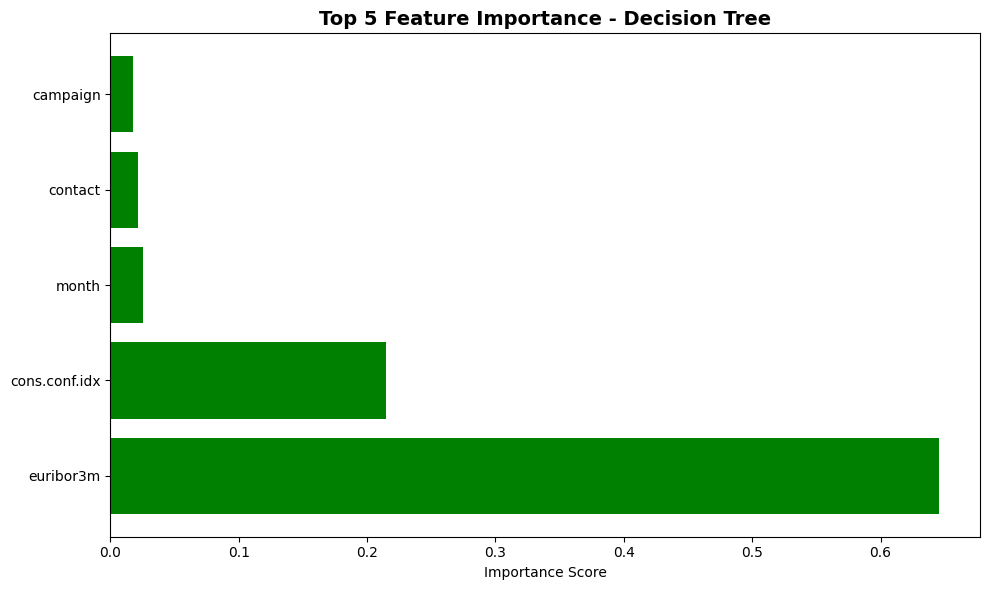

In [31]:
# Cell 12: Visualize Feature Importance
plt.figure(figsize=(10, 6))
top_n = 5
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'], color='green')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 5 Feature Importance - Decision Tree', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

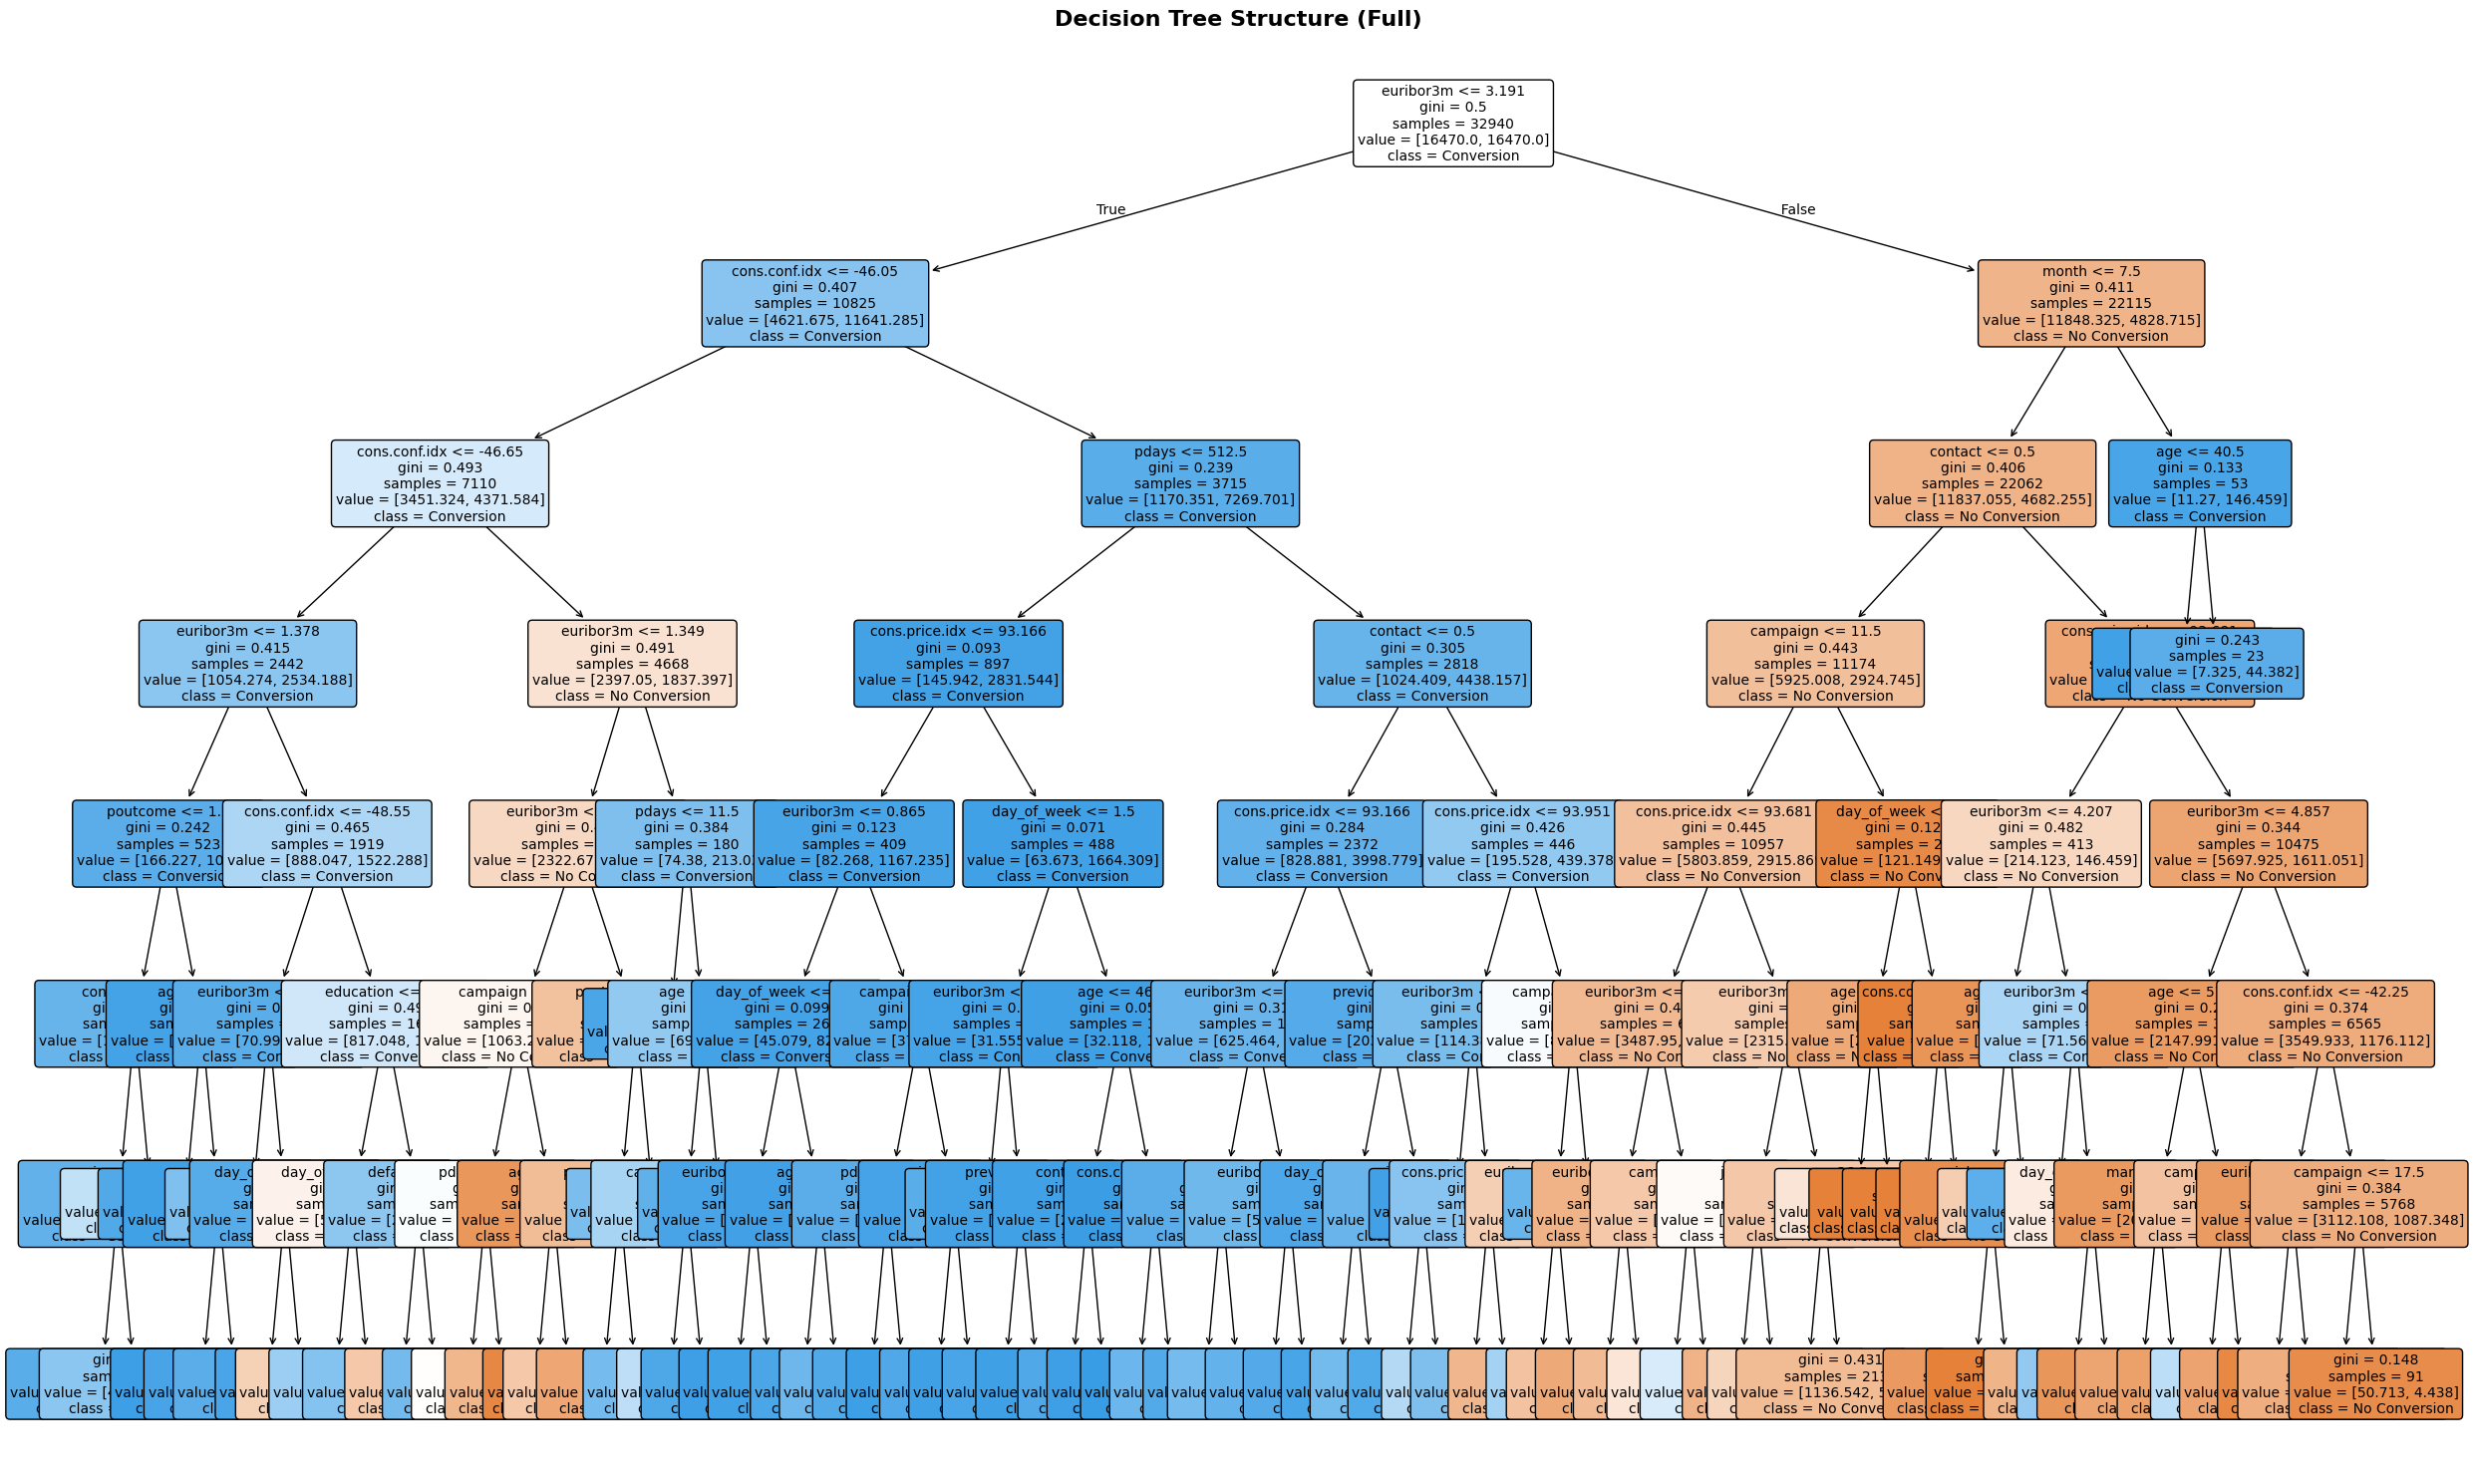

In [32]:
# Cell 13: Visualize Decision Tree (Full)
plt.figure(figsize=(25, 15))
plot_tree(dt_classifier, 
          feature_names=feature_names,
          class_names=['No Conversion', 'Conversion'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Structure (Full)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

In [33]:
# Cell 14: Extract Tree Rules as Text
tree_rules = export_text(dt_classifier, feature_names=feature_names)
print("\n" + "="*60)
print("DECISION TREE RULES (Text Format)")
print("="*60)
print(tree_rules[:2000])  # Print first 2000 characters


DECISION TREE RULES (Text Format)
|--- euribor3m <= 3.19
|   |--- cons.conf.idx <= -46.05
|   |   |--- cons.conf.idx <= -46.65
|   |   |   |--- euribor3m <= 1.38
|   |   |   |   |--- poutcome <= 1.50
|   |   |   |   |   |--- contact <= 0.50
|   |   |   |   |   |   |--- previous <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- previous >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- contact >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- poutcome >  1.50
|   |   |   |   |   |--- age <= 29.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  29.50
|   |   |   |   |   |   |--- age <= 49.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- age >  49.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- euribor3m >  1.38
|   |   |   |   |--- cons.conf.idx <= -48.55
|   |   |   |   |   |--- euribor3m <= 1.53
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |-

In [34]:
# Cell 15: Depth and Node Analysis
print("\n" + "="*60)
print("TREE STRUCTURE ANALYSIS")
print("="*60)
print(f"Tree Depth: {dt_classifier.get_depth()}")
print(f"Number of Leaves: {dt_classifier.get_n_leaves()}")
print(f"Number of Total Nodes: {dt_classifier.tree_.node_count}")


TREE STRUCTURE ANALYSIS
Tree Depth: 7
Number of Leaves: 81
Number of Total Nodes: 161


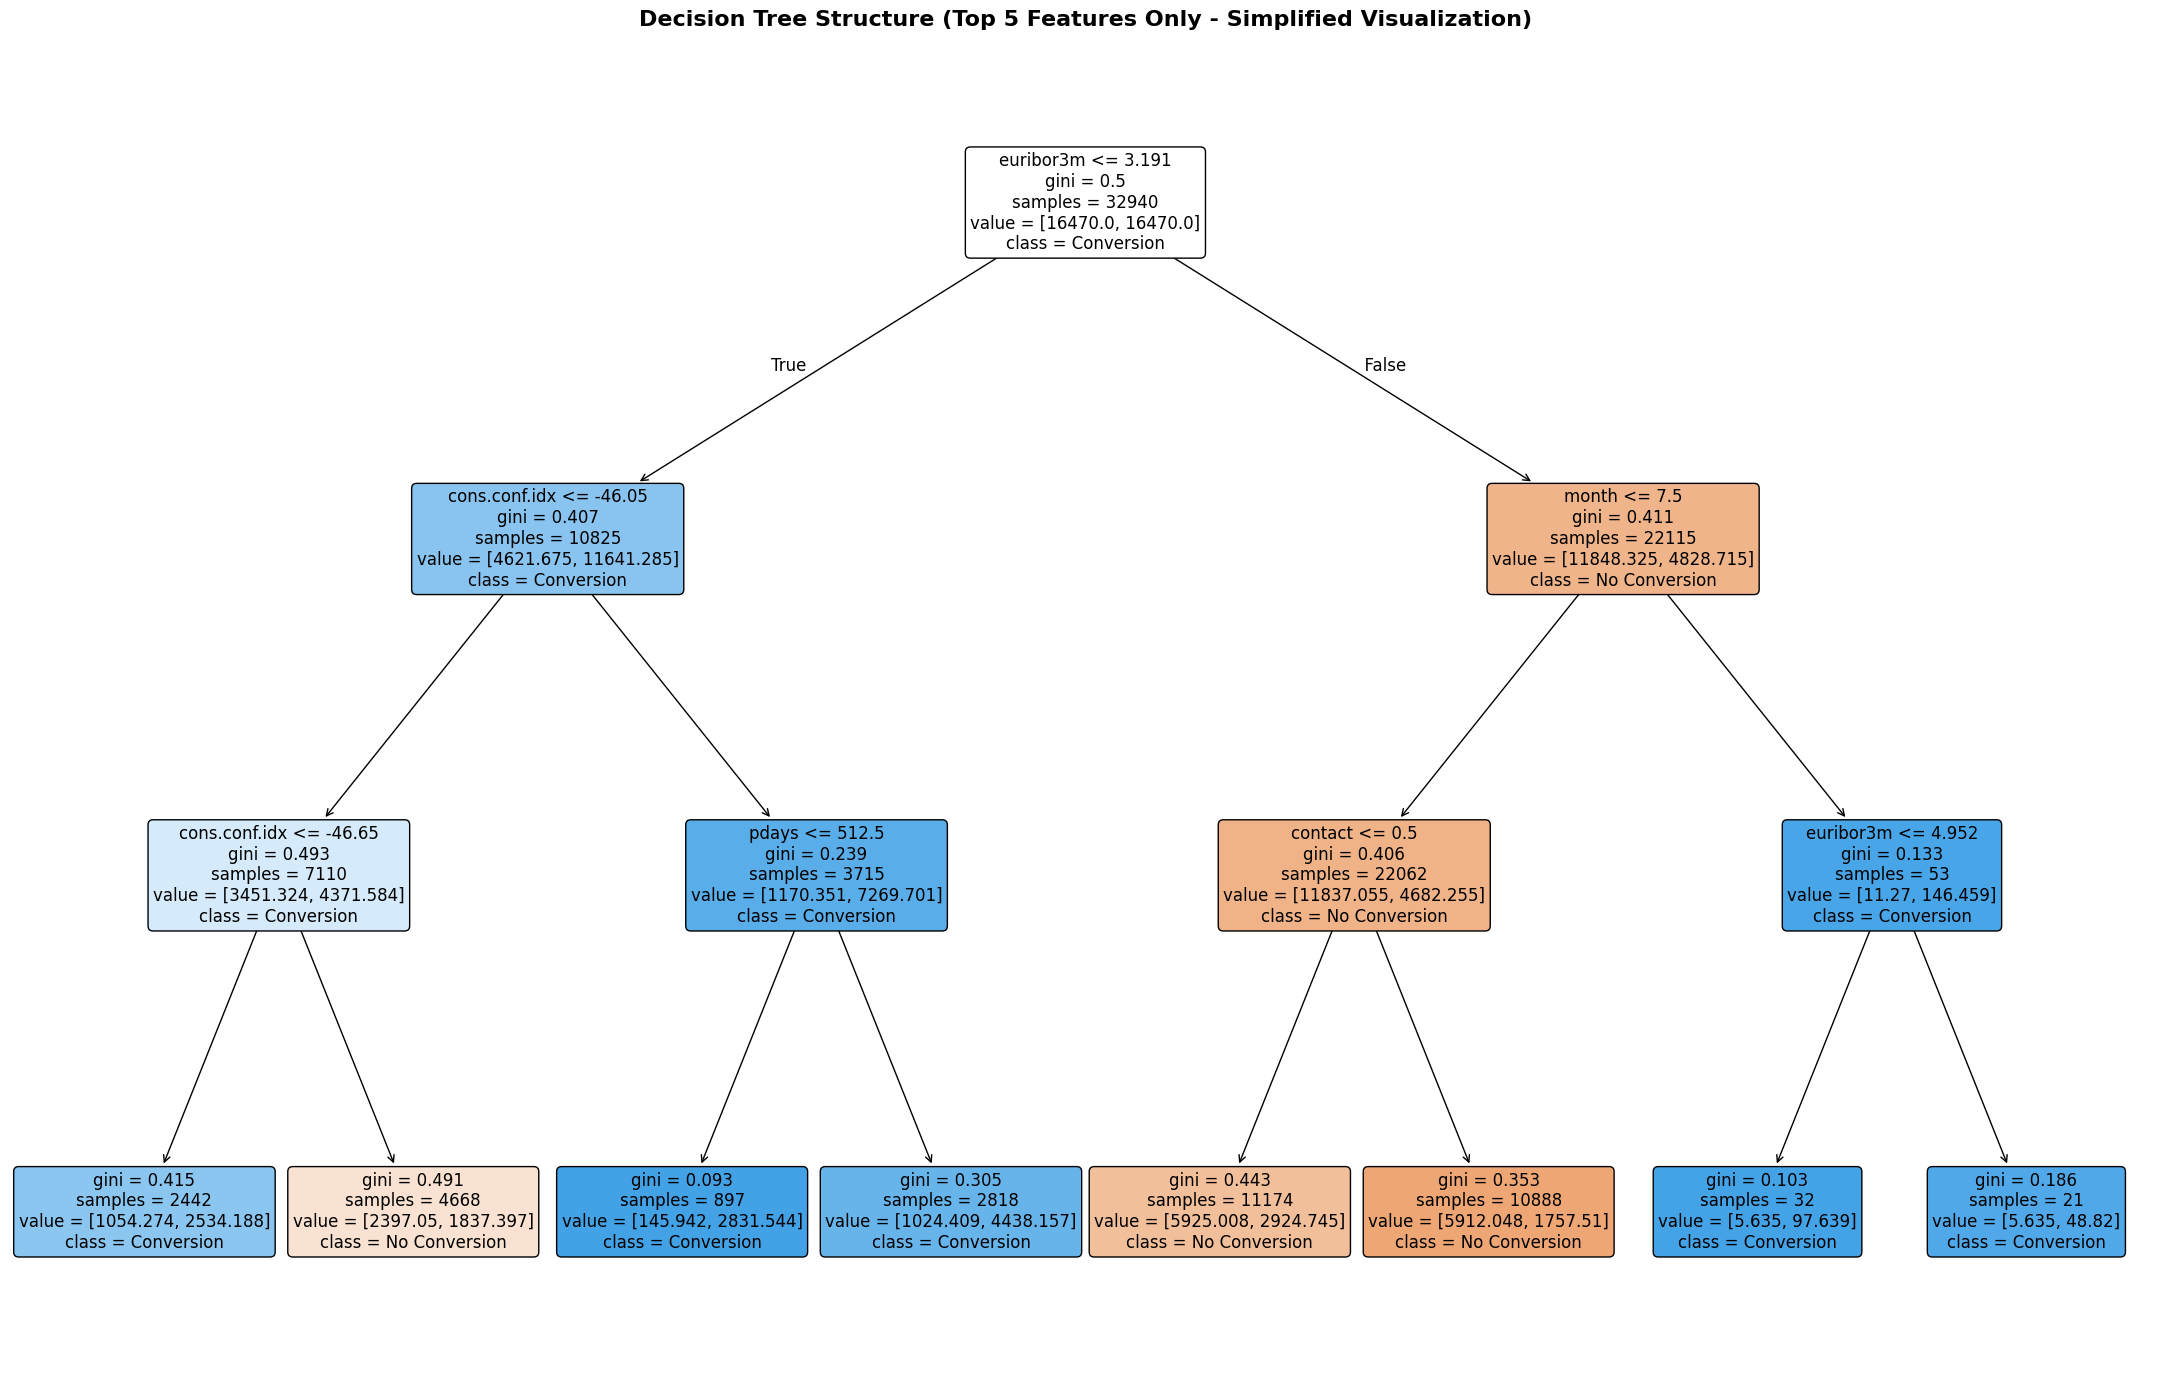


SIMPLIFIED TREE (TOP 5 FEATURES ONLY) 
Features used: ['euribor3m', 'cons.conf.idx', 'month', 'contact', 'pdays']
Tree depth: 3
Tree leaves: 8

Test Set Performance (Simplified Tree):
  Accuracy: 0.8381
  Precision: 0.3701
  Recall: 0.6218
  ROC-AUC: 0.7902


In [36]:
# Cell 13a: Visualize Simplified Decision Tree (Top 5 Features Only)
# Select only top 5 most important features
top_features = ['euribor3m', 'cons.conf.idx', 'month', 'contact', 'pdays']
top_feature_indices = [feature_names.index(f) for f in top_features]

X_train_top5 = X_train.iloc[:, top_feature_indices]
X_test_top5 = X_test.iloc[:, top_feature_indices]

dt_simple = DecisionTreeClassifier(
    max_depth=3,  # Increased depth since using fewer features
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42
)
dt_simple.fit(X_train_top5, y_train)

plt.figure(figsize=(22, 14))
plot_tree(dt_simple, 
          feature_names=top_features,
          class_names=['No Conversion', 'Conversion'],
          filled=True,
          rounded=True,
          fontsize=12)
plt.title('Decision Tree Structure (Top 5 Features Only - Simplified Visualization)', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SIMPLIFIED TREE (TOP 5 FEATURES ONLY) ")
print("="*80)
print(f"Features used: {top_features}")
print(f"Tree depth: {dt_simple.get_depth()}")
print(f"Tree leaves: {dt_simple.get_n_leaves()}")
print(f"\nTest Set Performance (Simplified Tree):")
y_test_pred_simple = dt_simple.predict(X_test_top5)
y_test_pred_proba_simple = dt_simple.predict_proba(X_test_top5)[:, 1]
print(f"  Accuracy: {(y_test_pred_simple == y_test).mean():.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_simple):.4f}")
print(f"  Recall: {recall_score(y_test, y_test_pred_simple):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_simple):.4f}")


ROI SEARCH - Model: Simplified Tree

 threshold  calls  conversions  precision   recall  revenue  cost  net_profit
      0.10   8236          928   0.112676 1.000000   185600 41180      144420
      0.15   8236          928   0.112676 1.000000   185600 41180      144420
      0.20   8236          928   0.112676 1.000000   185600 41180      144420
      0.25   5479          828   0.151122 0.892241   165600 27395      138205
      0.30   5479          828   0.151122 0.892241   165600 27395      138205
      0.35   2684          687   0.255961 0.740302   137400 13420      123980
      0.40   2684          687   0.255961 0.740302   137400 13420      123980
      0.45   1559          577   0.370109 0.621767   115400  7795      107605
      0.50   1559          577   0.370109 0.621767   115400  7795      107605

RECOMMENDED THRESHOLD (Profit-max): 0.10
Final Performance (at recommended threshold):
  Precision: 0.1127
  Recall:    1.0000

Profit summary:
  Baseline threshold 0.50 -> Net prof

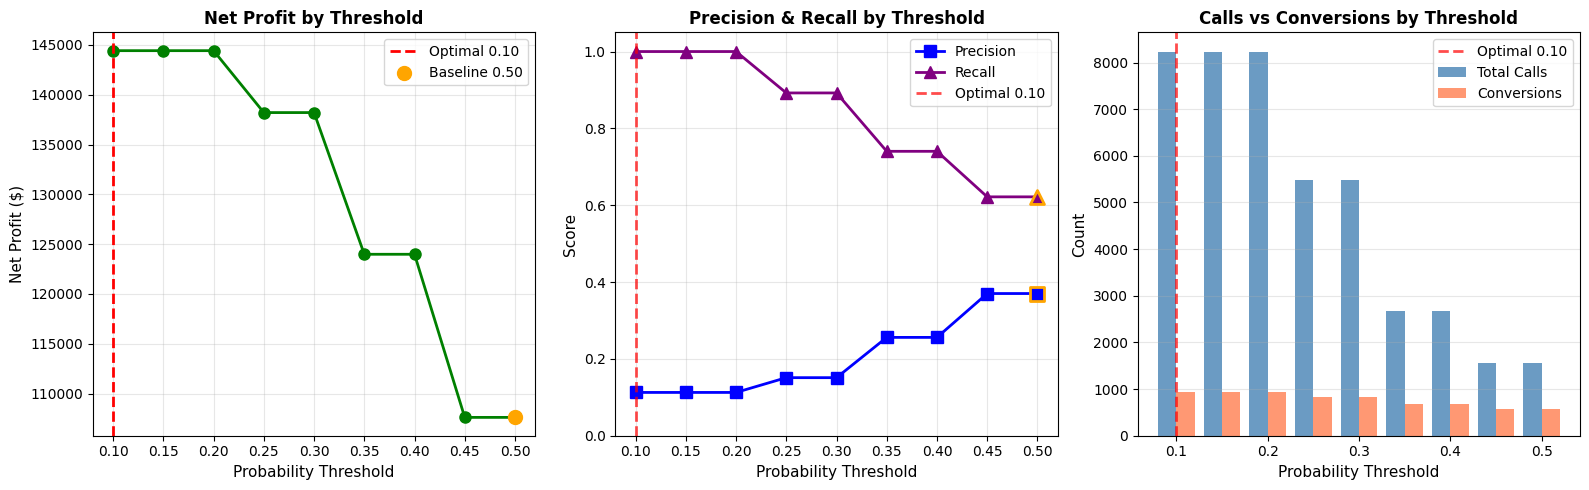

In [42]:
# Cell 16: ROI / Optimal Threshold search (0.10 to 0.50 step 0.05) with Precision & Recall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# BUSINESS VARIABLES (change if needed)
COST_PER_CALL = 5         # $ per call (bank cost)
REVENUE_PER_DEAL = 200     # $ revenue per successful conversion (LTV)

# Use simplified-tree probabilities if available, else fall back to full model probabilities
try:
    probs = y_test_pred_proba_simple
    model_label = 'Simplified Tree'
except NameError:
    probs = y_test_pred_proba
    model_label = 'Full Decision Tree'

# If probs is a 2D array from predict_proba, take column 1
if isinstance(probs, np.ndarray) and probs.ndim > 1:
    probs = probs[:, 1]
else:
    probs = np.asarray(probs).ravel()

# Thresholds from 0.10 to 0.50 inclusive, step 0.05
thresholds = np.arange(0.10, 0.51, 0.05)
results = []

best_profit = -np.inf
best_threshold = None

for t in thresholds:
    preds = (probs >= t).astype(int)
    calls = int(preds.sum())                     # number of calls we would make
    conversions = int(((preds == 1) & (y_test == 1)).sum())  # true positives
    revenue = conversions * REVENUE_PER_DEAL
    cost = calls * COST_PER_CALL
    net_profit = revenue - cost
    
    # Compute precision and recall for this threshold
    precision = precision_score(y_test, preds, zero_division=0)
    recall = recall_score(y_test, preds, zero_division=0)

    results.append({
        'threshold': float(t),
        'calls': calls,
        'conversions': conversions,
        'precision': precision,
        'recall': recall,
        'revenue': revenue,
        'cost': cost,
        'net_profit': net_profit
    })

    if net_profit > best_profit:
        best_profit = net_profit
        best_threshold = float(t)

results_df = pd.DataFrame(results)

# Print full results for all thresholds
print('\n' + '='*100)
print(f'ROI SEARCH - Model: {model_label}')
print('='*100 + '\n')
print(results_df.to_string(index=False))

# Baseline (standard 0.5 threshold) comparison
baseline_t = 0.5
baseline_preds = (probs >= baseline_t).astype(int)
baseline_calls = int(baseline_preds.sum())
baseline_conversions = int(((baseline_preds == 1) & (y_test == 1)).sum())
baseline_revenue = baseline_conversions * REVENUE_PER_DEAL
baseline_cost = baseline_calls * COST_PER_CALL
baseline_profit = baseline_revenue - baseline_cost
baseline_precision = precision_score(y_test, baseline_preds, zero_division=0)
baseline_recall = recall_score(y_test, baseline_preds, zero_division=0)

# Best (optimal) row
best_row = results_df[results_df['threshold'] == best_threshold].iloc[0]

# Print recommended threshold and only precision & recall as requested
y_opt = (probs >= best_threshold).astype(int)
print('\n' + '='*70)
print(f'RECOMMENDED THRESHOLD (Profit-max): {best_threshold:.2f}')
print('='*70)
print('Final Performance (at recommended threshold):')
print(f'  Precision: {best_row["precision"]:.4f}')
print(f'  Recall:    {best_row["recall"]:.4f}')

print('\nProfit summary:')
print(f'  Baseline threshold {baseline_t:.2f} -> Net profit: ${baseline_profit:,.0f} (Calls: {baseline_calls}, Conversions: {baseline_conversions})')
print(f'  Optimal threshold {best_threshold:.2f} -> Net profit: ${best_row['net_profit']:,.0f} (Calls: {int(best_row['calls'])}, Conversions: {int(best_row['conversions'])})')
delta = best_row['net_profit'] - baseline_profit
pct = (delta / abs(baseline_profit)) * 100 if baseline_profit != 0 else float('nan')
print()
if delta >= 0:
    print(f'  MONEY SAVED / ADDED PROFIT by using optimal threshold: ${delta:,.0f} ({pct:.1f}% vs baseline)')
else:
    print(f'  MONEY LOST by using optimal threshold: ${-delta:,.0f} ({pct:.1f}% vs baseline)')

# Create a comprehensive 3-panel visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Net Profit by Threshold
axes[0].plot(results_df['threshold'], results_df['net_profit'], marker='o', lw=2, markersize=8, color='green')
axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal {best_threshold:.2f}')
axes[0].scatter([baseline_t], [baseline_profit], color='orange', zorder=5, s=100, label=f'Baseline {baseline_t:.2f}')
axes[0].set_xlabel('Probability Threshold', fontsize=11)
axes[0].set_ylabel('Net Profit ($)', fontsize=11)
axes[0].set_title('Net Profit by Threshold', fontweight='bold', fontsize=12)
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=10)

# Panel 2: Precision & Recall by Threshold
axes[1].plot(results_df['threshold'], results_df['precision'], marker='s', lw=2, markersize=8, label='Precision', color='blue')
axes[1].plot(results_df['threshold'], results_df['recall'], marker='^', lw=2, markersize=8, label='Recall', color='purple')
axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal {best_threshold:.2f}')
axes[1].scatter([baseline_t], [baseline_precision], color='blue', marker='s', zorder=5, s=100, edgecolor='orange', linewidth=2)
axes[1].scatter([baseline_t], [baseline_recall], color='purple', marker='^', zorder=5, s=100, edgecolor='orange', linewidth=2)
axes[1].set_xlabel('Probability Threshold', fontsize=11)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Precision & Recall by Threshold', fontweight='bold', fontsize=12)
axes[1].set_ylim([0, 1.05])
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize=10)

# Panel 3: Calls vs Conversions by Threshold
ax3 = axes[2]
ax3.bar(results_df['threshold'] - 0.01, results_df['calls'], width=0.02, label='Total Calls', alpha=0.8, color='steelblue')
ax3.bar(results_df['threshold'] + 0.01, results_df['conversions'], width=0.02, label='Conversions', alpha=0.8, color='coral')
ax3.axvline(best_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal {best_threshold:.2f}')
ax3.set_xlabel('Probability Threshold', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Calls vs Conversions by Threshold', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3, axis='y')
ax3.legend(fontsize=10)

plt.tight_layout()
plt.show()
